In [1]:
import sys
import warnings
warnings.filterwarnings(action='ignore')
import collections
from IPython.display import display
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split

mpl.rcParams['axes.unicode_minus'] = False
font_fname = '/Users/seongdae/Library/Fonts/NanumGothicLight.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc('font', family=font_name)
# size, family
print ('font size : '+str(plt.rcParams['font.size']) )
print ('font family : '+str(plt.rcParams['font.family']) )
# import default setting
print('python version : {0}\npandas version : {1}\nmatplotlib version : {2}\nnumpy version : {3}\n'
.format(sys.version, pd.__version__, mpl.__version__, np.__version__))

font size : 10.0
font family : ['NanumGothic']
python version : 3.7.6 (v3.7.6:43364a7ae0, Dec 18 2019, 14:18:50) 
[Clang 6.0 (clang-600.0.57)]
pandas version : 0.25.3
matplotlib version : 3.1.2
numpy version : 1.18.1



# 분류 예측의 불확실성 추정

In [2]:
# scikit-learn에서 많이 사용하는 인터페이스 중 하나는 분류기에 예측의 불확실성을 추가할 수 있는 기능
# 어떤 테스트 포인트에 대해 분류기가 예측한 클래스가 무엇인지 뿐만 아니라, 정확한 클래스임을 얼마나 확신하는지가 중요할 떄가 있음
    # 얼마나 정확한_올바른의미를가진 예측을 한 것인가
# 실제 application에서는 오류의 종류에 따라 전혀 다른 결과를 만듬
    # 의료 예측 application에서는 거짓 양성 예측은 환자가 추가 진료를 요구하지만
    # 거짓 음성 예측은 심각한 질병을 치료하지 못하게 할 수 있음

# scikit-learn에서는 decision_function, predict_proba 함수를 이용할 수 있음, 측정을 위해, 결정함수..?

## 결정함수

In [3]:
# GradientBoostingClassifier 분류기의 decision_function, predict_proba 예제
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

X, y = make_circles(noise=.25, factor=.5, random_state=1)
y_named = np.array(['blue','red'])[y] # labeling 0, 1 -> blue, red

# 다수의 배열을 train_test_split 함수에 넣을 수 있음, 훈련 테스트로 나뉘는 방식은 동일
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# 그래디언트 부스팅
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train_named)

In [4]:
print('X_test shape : ',X_test.shape)
print('결정함수 결과 형태 : ', gbrt.decision_function(X_test).shape)
    # 반환값 : (n_smaples, ) 각 샘플이 하나의 실수 값을 반환함
# 결정함수 결과 중 앞부분 일부 확인
print('결정함수 : \n', gbrt.decision_function(X_test)[:6])
# 값 양성 : 클래스 1에 속한다고 믿는 정도, 음성 : 클래스 0(다른 클래스)를 의미

X_test shape :  (25, 2)
결정함수 결과 형태 :  (25,)
결정함수 : 
 [ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [5]:
# 결정 함수의 부호를 보고 예측 결과를 알 수 있음

print('임계치(0)와 결정 함수 결과 비교 : \n', gbrt.decision_function(X_test) > 0)
print('예측 : \n', gbrt.predict(X_test))
# 음수 -> blue, 양수 -> red

임계치(0)와 결정 함수 결과 비교 : 
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
예측 : 
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [6]:
# 이진분류에서 음성 클래스는 항상 classes_속성의 첫번째 원소이고, 양성 클래스는 classes_속성의 두번째 원소
# 그러므로, predict 함수의 결과를 완전히 재현하려면 classes 속성 사용

# boolean 값들을 0,1 변환
greater_zero = (gbrt.decision_function(X_test)>0).astype(int)

# classes_ 에 인덱스로 사용
pred = gbrt.classes_[greater_zero]

# pred값과 gbrt,predict 비교
print('같은가? ',np.all(pred == gbrt.predict(X_test)))

같은가?  True


In [7]:
# 결정함수의 범위는 데이터와 모델 파라미터에 따라 달라짐
decision_function = gbrt.decision_function(X_test)
print('결정 함수 최솟값 : {:.4f}\n결정함수 최댓값 : {:.4f}'.format(np.min(decision_function), np.max(decision_function)))

# 출력범위는 임의의 값이기 때문에, 왜 이런값이 나오는지 이해하기 힘듬

결정 함수 최솟값 : -7.6910
결정함수 최댓값 : 4.2899


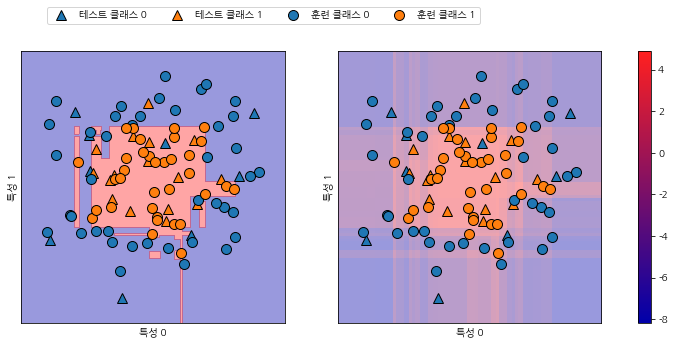

In [8]:
# 2차원 평면의 모든 점에 대해 decision_function 의 값을 색으로 표현, 결정 경계와 함께 그래프로 표현
# train 원, test 삼각형
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
score_img = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 훈련 포인트와 테스트 포인트 그리기
    mglearn.discrete_scatter(X_test[:,0], X_test[:,1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train, markers='o', ax=ax)
    ax.set_xlabel('특성 0')
    ax.set_ylabel('특성 1')
cbar = plt.colorbar(score_img, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(['테스트 클래스 0', '테스트 클래스 1', '훈련 클래스 0', '훈련 클래스 1'], ncol=4, loc=(.1, 1.1))

In [9]:
# 좌_ 결정 경계, 우_ 결정 함수
# 예측한 결과 뿐 아니라, 얼마나 확신하는지 알면 추가정보를 얻게됨
# 그러나 결정함수 그래프에서 구 클래스 사이의 경계를 구분하기는 어려움


## 예측 확률

In [10]:
# predict_proba의 출력은 각 클래스에 대한 확률
# decision_function의 출력보다 이해하기 더 쉬움

# 이 값의 크기(predict_proba)의 크기는 이진분류에서 항상 (n_samples, 2)임
print('예측 확률 값의 형태 : ', gbrt.predict_proba(X_test).shape)

# 각 행의 첫번째 원소는 첫번째 클래스의 예측 확률, 두번째 원소는 두번째 클래스의 예측 확률
# 확률이기때문에, predict_proba의 출력은 항상 0과 1 사이이며, 두 클래스의 대한 확률의 합은 항상 1임

예측 확률 값의 형태 :  (25, 2)


In [11]:
# predict_proba 의 앞부분 일부 확인
print('예측 확률 : \n', gbrt.predict_proba(X_test[:6]))

# 두 클래스의 확률 합은 1, 두 클래스중 하나는 반드시 50%이상의 값을 가지고 있음, 만약 정말 50.000 50.00 이라면 랜덤하게 하나를 선택함
# 그 클래스가 예측값이 됨

예측 확률 : 
 [[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


In [12]:
# 대부분의 클래스에서 비교적 강하게 분류되고 있음
# 데이터에 있는 불확실성이 얼마나 이 값에 잘 반영되는지에는 모델과 매개변수 설정에 달려있음
# 과적합된 모델은 잘못된 예측이더라도 예측의 확신이 강한편
# 일반적으로 복잡도가 낮은 모델은 예측에 불확실성이 더 많음
# 불확실성과 모델의 정확도가 동등하면 이 모델이 보정(calibraction) 되었다고 함
    # 즉 보정된 모델에서 70% 확신을 가진 예측은 70%의 정확도를 낼것

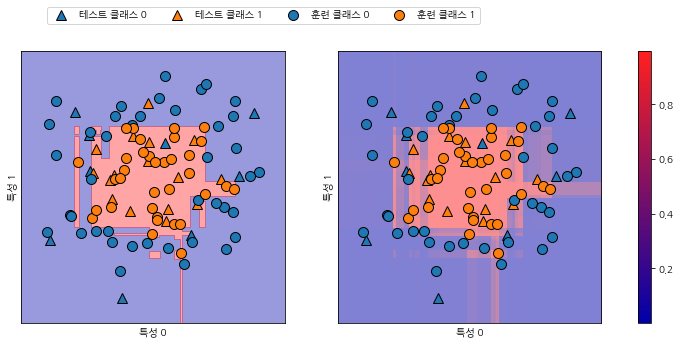

In [13]:
# 결정 경계와 클래스 1의 확률
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 훈련 포인트와 테스트 포인트
    mglearn.discrete_scatter(X_test[:,0], X_test[:,1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train, markers='o', ax=ax)
    ax.set_xlabel('특성 0')
    ax.set_ylabel('특성 1')
    
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(['테스트 클래스 0','테스트 클래스 1','훈련 클래스 0','훈련 클래스 1'], ncol=4, loc=(.1, 1.1))

In [14]:
# decision_function 보다 predict_proba의 경계가 잘 나타나있으며, 불확실성이 있는 작은 영역도 잘 확인할 수 있음

# 다중 분류에서의 불확실성

In [15]:
# decision_function, predict_proba 메서드는 다중 분류에서도 사용 가능
# class 3개 iris dataset

In [24]:
from sklearn.datasets import load_iris

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0).fit(X_train, y_train)

print('결정 함수의 결과 형태 : ', gbrt.decision_function(X_test).shape)
print('결정 함수 결과[6] : ', gbrt.decision_function(X_test)[:6,:])
# 결과값의 크기 (n_samples, n_classes)
    # 각 3개의 클래스일 확률


결정 함수의 결과 형태 :  (38, 3)
결정 함수 결과[6] :  [[-1.9957153   0.04758118 -1.92721297]
 [ 0.0614655  -1.90755689 -1.92793177]
 [-1.99058105 -1.87637856  0.09686741]
 [-1.9957153   0.04758118 -1.92721297]
 [-1.99730166 -0.13469231 -1.20341532]
 [ 0.0614655  -1.90755689 -1.92793177]]


In [28]:
# 수치가 가장 높은 값들을 선택해서 예측 가능
print('가장 큰 결정함수의 인덱스 :\n', np.argmax(gbrt.decision_function(X_test), axis=1))
print('예측 함수 :\n', gbrt.predict(X_test))

가장 큰 결정함수의 인덱스 :
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측 함수 :
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [29]:
# predict_proba 의 각 클래스 예측값들의 합은 이진 분류와 마찬가지로 1
# predict_proba 결과 중 앞부분 일부를 확인함
print('예측 확률 :\n', gbrt.predict_proba(X_test)[:6])
# 행 방향으로 확률 값들의 합
print('합 : ', gbrt.predict_proba(X_test)[:6].sum(axis=1))

예측 확률 :
 [[0.10217734 0.78840063 0.10942203]
 [0.7834712  0.1093673  0.1071615 ]
 [0.09818079 0.11005862 0.79176059]
 [0.10217734 0.78840063 0.10942203]
 [0.10360014 0.66723882 0.22916105]
 [0.7834712  0.1093673  0.1071615 ]]
합 :  [1. 1. 1. 1. 1. 1.]


In [30]:
# argmax 함수 적용, 예측과 동일시행 가능
print('가장 큰 예측 확률의 인덱스 : \n', np.argmax(gbrt.predict_proba(X_test), axis=1) )
print('예측 : \n', gbrt.predict(X_test))

가장 큰 예측 확률의 인덱스 : 
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측 : 
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [31]:
# 다중 분류에서의 predict_proba 와 decision_function 의 크기는 항상 (n_samples, n_classes)임
# 이진 분류에서의 decision_function 은 조금 다름, (n_samples,)인데, classes_[1]에 대응 하는 값만을 가지고 있음
    # classes_[1]에 대한 양성 예측, 음성 예측
# 열이 n_classes개 일때는 열을 가로 질러서 argmax함수를 적용해 예측 할 수 있으나
# 클래스가 문자열이거나, 정수형을 사용하지만 연속적이지 않거나, 0부터 시작하지 않을 수 있음
    # predict 의 결과와 decision_function or predict_proba 의 결과를 비교하려면 분류기의 classes_ 속성을 활용해
    # 실제 이름을 얻어야함
gbrt.classes_

array([0, 1, 2])

### 분류기의 classes_연결

In [42]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print('훈련 데이터에 있는 클래스 종류 : ', logreg.classes_)
print('예측 : ', logreg.predict(X_test))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print('가장 큰 결정 함수의 인덱스 : ', argmax_dec_func)
print('인덱스를 classes_에 연결 : ', logreg.classes_[argmax_dec_func])

훈련 데이터에 있는 클래스 종류 :  ['setosa' 'versicolor' 'virginica']
예측 :  ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa'
 'setosa' 'setosa' 'versicolor' 'setosa' 'setosa' 'virginica' 'versicolor'
 'setosa']
가장 큰 결정 함수의 인덱스 :  [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
인덱스를 classes_에 연결 :  ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa'
 'setosa' 'setosa' 'versicolor' 'setosa' 'se

## 정리

In [43]:
# 최근접 이웃
    # 작은 데이터셋일 경우, 기본 모델로서 좋고 설명되기 쉬움
# 선형 모델
    # 첫 번째로 시도할 알고리즘, 대용량 데이터셋에 적용 가능, 고차원 데이터셋에 적용 가능
# 나이브 베이즈
    # 분류 모델(회귀 x), 선형 모델보다 훨씬 빠름, 대용량 데이터셋과 고차원 데이터셋에 적용가능, 선형 모델보다 덜 정확함
    
# 결정 트리
    # 매우 빠름, 데이터 스케일 조정 필요 없음, 시각화하기 좋음, 설명되기 쉬움
# 랜덤 포레스트
    # 결정 트리 하나보다 거의 항상 좋은 성능을 보여줌, 매우 안정적이고 강력함, 데이터 스케일 조정 필요 없음, 고차원 희소데이터 잘 안맞음
# 그래디언트 부스팅 결정 트리
    # 랜덤 포레스트보다 성능 조금 더 좋음, 랜덤 포레스트보다 학습은 느리나, 예측은 빠름, 메모리 적게 사용, 랜덤 포레스트보다 매개변수 튜닝 많이 필요

# 서포트 벡터 머신
    # 비슷한 의미의 특성으로 이뤄진 중간 규모 데이터셋에 잘 맞음, 데이터 스케일 조정 필요, 매개변수에 민감
    # C, gamma : 
        # C 규제(L2)
        # gamma 유클리디안 거리_지수의 역, 결정 경계의 각 포인트 벡터와의 간격

# 신경망
    # 특별히 대용량 데이터셋에서 매우 복잡한 모델을 만들 수 있음
    # 매개변수 선택과 데이터 스케일에 민감, 큰 모델 학습 오래걸림

In [ ]:
# 새로운 데이터셋으로 작업할 때는 선형 모델 or 나이브 베이즈 or K-NN최근접이웃 같은 간단한 모델 작업 ->
# 데이터를 이해한 후, 랜덤 포레스트나 그래디언트부스팅 결정트리, SVM, 신경망 과 같은 복잡한 모델을 만들 수 있는 알고리즘 고려
